In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Attention
from keras import optimizers 
from sklearn.metrics import mean_squared_error

seed = 2345
np.random.seed(seed)
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data_raw = pd.read_csv("VNM.csv", index_col="Date", parse_dates=["Date"])
data_raw = data_raw.dropna()

 Count row of data:  988


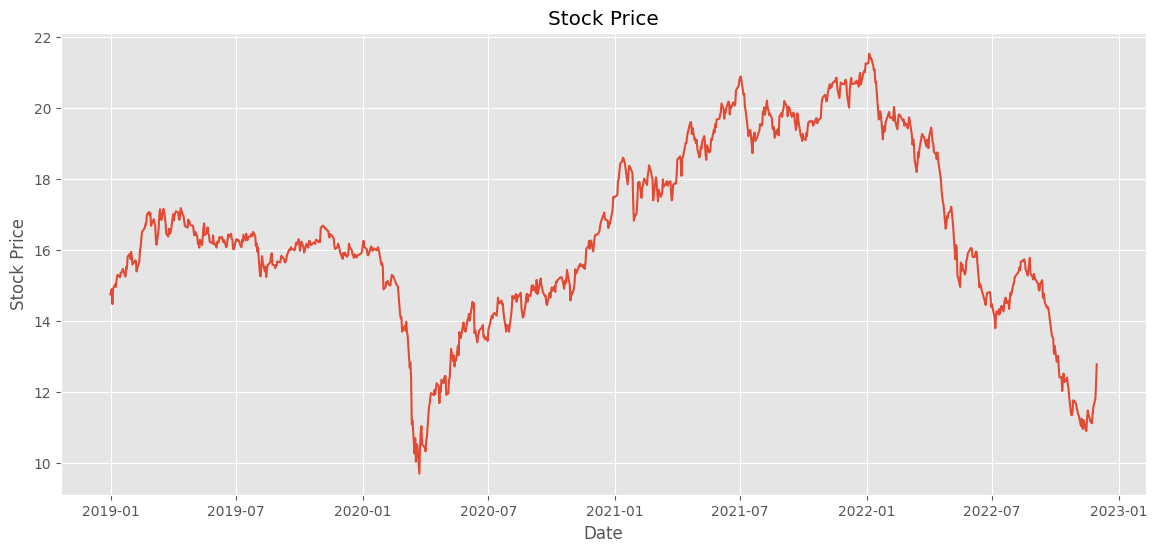

In [4]:
dataset = pd.DataFrame(data_raw['Close'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Stock Price')
plt.show()

In [5]:
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
Date,
2018-12-31,0.426881
2019-01-02,0.439560
2019-01-03,0.404057
2019-01-04,0.440406
2019-01-07,0.451395
...,...
2022-11-23,0.120034
2022-11-25,0.158073
2022-11-28,0.177515


In [18]:
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.75)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.15)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

In [19]:
# Initiaton value of lag
lag = 2
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [20]:
learning_rate = 0.0001
hidden_unit = 64
batch_size = 32
epoch = 100

model = Sequential()

model.add(LSTM(units=hidden_unit, return_sequences=True, input_shape = (x_train.shape[1],1), activation="relu"))
model.add(Dropout(0.2))

model.add(LSTM(units=hidden_unit, return_sequences=True, activation="relu"))
model.add(Dropout(0.2))

model.add(LSTM(units=hidden_unit, return_sequences=False, activation="relu"))
model.add(Dropout(0.2))
Attention()

model.add(Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss='mean_squared_error')

pred = model.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)

Epoch 1/100
24/24 [==============================] - 4s 21ms/step - loss: 0.3095 - val_loss: 0.4547
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0966 - val_loss: 0.0026
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0231 - val_loss: 0.0341
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0185 - val_loss: 0.0124
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0042
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0023
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0014
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 8.3535e-04
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0011
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0013
Epoc

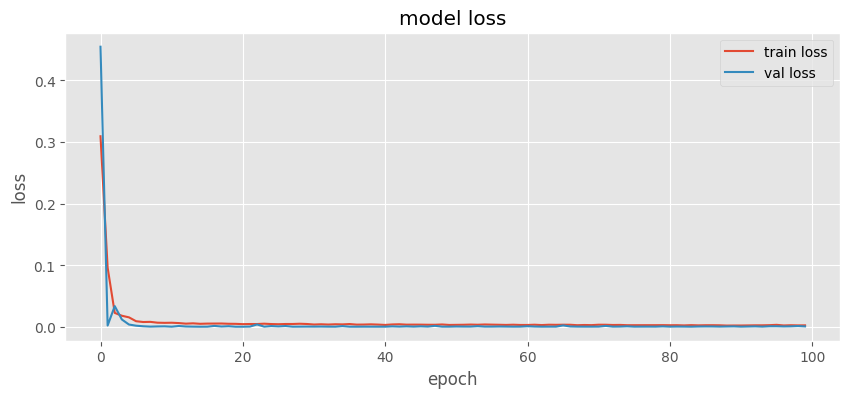

In [21]:
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [22]:
learningrate_parameter = learning_rate
train_loss=pred.history['loss'][-1]
validation_loss=pred.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.0001,0.002882,0.001173


In [23]:
# Implementation model into data test
y_pred_test = model.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

5/5 [==============================] - 1s 2ms/step


In [24]:
set_test = dataset["Close"]

In [25]:
datacompare = pd.DataFrame()
datatest=np.array(set_test[totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
datacompare

,Data Test,Prediction Results
0,17.219999,16.904112
1,17.059999,16.977209
2,16.860001,17.034828
3,16.620001,16.867296
4,15.740000,16.664307
...,...,...
142,11.120000,11.170403
143,11.570000,11.162166
144,11.800000,11.184100
145,12.200000,11.392863


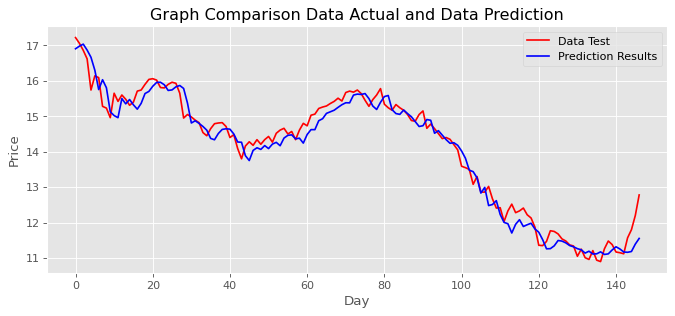

In [26]:
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [27]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
MAPE(datatest, datapred)

13.602509045421222

In [28]:
from sklearn.metrics import mean_squared_error
import math
MSE = mean_squared_error(datatest, datapred)
RMSE = math.sqrt(MSE)
print(RMSE)

0.3160646100778457


In [29]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(
    y_true=datatest,
    y_pred=datapred
)

0.24485085892367206

Làm file lab thì tới đây thôi nha, phần dưới khỏi

In [30]:
n_ahead=input("How many values do you want to predict ?");
n_ahead=int(n_ahead)
# Making the prediction list 
def predict_ahead(n_ahead, X_train):
   yhat = []
   for _ in range(n_ahead):
   # Making the prediction
       fc = model.predict(X_train)
       yhat.append(fc)

   # Creating a new input matrix for forecasting
       X_train = np.append(X_train, fc)

   # Ommitting the first variable
       X_train = np.delete(X_train, 0)


   # Reshaping for the next iteration
       X_train = np.reshape(X_train, (1, len(X_train), 1))

   return yhat 
y30 = predict_ahead(n_ahead, x_test[len(x_test)-30:])

1/1 [==============================] - 0s 29ms/step


In [31]:
y30

[array([[0.18926813],
        [0.19288345],
        [0.17922328],
        [0.17135394],
        [0.15373808],
        [0.13191982],
        [0.1322853 ],
        [0.13901147],
        [0.15174748],
        [0.15030223],
        [0.14603812],
        [0.13965754],
        [0.13664417],
        [0.13223079],
        [0.12951644],
        [0.12169103],
        [0.12614945],
        [0.11950561],
        [0.1199374 ],
        [0.12462983],
        [0.11845326],
        [0.11982806],
        [0.12910786],
        [0.13670777],
        [0.13156548],
        [0.12429448],
        [0.12359807],
        [0.12545225],
        [0.1430991 ],
        [0.15664022]], dtype=float32),
 array([[-4.6898866e+33]], dtype=float32),
 array([[-4.722194e+33]], dtype=float32),
 array([[-5.5797436e+33]], dtype=float32),
 array([[-1.3455467e+34]], dtype=float32),
 array([[-4.967281e+34]], dtype=float32),
 array([[-1.7910837e+35]], dtype=float32),
 array([[-6.186947e+35]], dtype=float32),
 array([[-2.212292e+36]],

In [40]:
y30 = [[0.18926813],
        [0.19288345],
        [0.17922328],
        [0.17135394],
        [0.15373808],
        [0.13191982],
        [0.1322853 ],
        [0.13901147],
        [0.15174748],
        [0.15030223],
        [0.14603812],
        [0.13965754],
        [0.13664417],
        [0.13223079],
        [0.12951644],
        [0.12169103],
        [0.12614945],
        [0.11950561],
        [0.1199374 ],
        [0.12462983],
        [0.11845326],
        [0.11982806],
        [0.12910786],
        [0.13670777],
        [0.13156548],
        [0.12429448],
        [0.12359807],
        [0.12545225],
        [0.1430991 ],
        [0.15664022]]

In [41]:
y30 = scaler.inverse_transform(y30)
y30

array([[11.93904217],
       [11.98181141],
       [11.82021158],
       [11.72711728],
       [11.51872164],
       [11.2606116 ],
       [11.26493523],
       [11.34450583],
       [11.49517284],
       [11.47807553],
       [11.42763111],
       [11.35214884],
       [11.31650067],
       [11.26429038],
       [11.23217961],
       [11.13960501],
       [11.19234812],
       [11.11375149],
       [11.11885956],
       [11.17437101],
       [11.10130218],
       [11.11756607],
       [11.22734611],
       [11.31725306],
       [11.25641976],
       [11.17040382],
       [11.16216529],
       [11.18410024],
       [11.3928625 ],
       [11.55305396]])

In [43]:
from numpy import savetxt
savetxt('A-LSTM.csv', y30, delimiter=',')

In [45]:
data30 = pd.read_csv("B-LSTM.csv")
data30 = data30.dropna()
type(data30)

pandas.core.frame.DataFrame

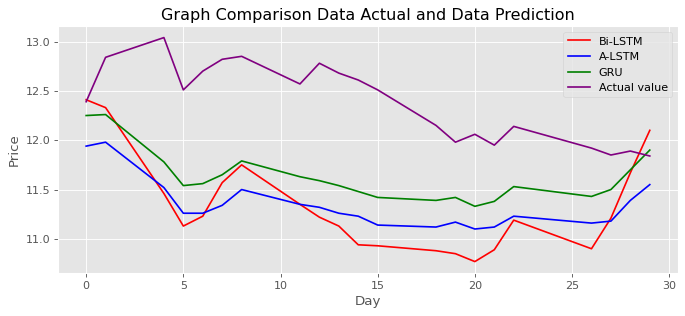

In [47]:
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(data30['Bi-LSTM'], color='red',label='Bi-LSTM')
plt.plot(data30['A-LSTM'], color='blue',label='A-LSTM')
plt.plot(data30['GRU'], color='green',label='GRU')
plt.plot(data30['actual'], color='purple',label='Actual value')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()